### Import Necessary Classes

In [18]:
# last update 11.03.2023
import numpy as np, panel as pn
import hvplot.pandas
import hvplot.dask
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from datetime import *

hvplot.extension('matplotlib')
pn.extension()
output_notebook()

Loading BokehJS ...

### Load Data

In [19]:
df = pd.read_csv('choice_member_info.csv', dtype={'Agreement #':'string','Member Name (first last)':'string',
                                                'Sales Person (first last)':'string','Campaign':'string',
                                                'Membership Type':'string','Latest Agreement Type':'string',
                                                'Membership State':'string','Status Description':'string',
                                                'Status Date':'string','UDF_AGREEMENTS_007':'string','Address':'string',
                                                'City':'string','Zip':'string','Has Active Recurring Service':'string'})
print(df.head())

  Agreement # Member Name (first last) Sales Person (first last)  \
0  4016500002              JOSE N DIAZ                      <NA>   
1  4016500003           WILGEN  GARCIA                      <NA>   
2  4016500022      JHOVANNY  VILLALONA          Damien  Hamilton   
3  4016500027           ALIYAH J MOREL          Damien  Hamilton   
4  4016500028         ADONIS A REYNOSO          Damien  Hamilton   

  Date Converted to Member Campaign Membership Type Latest Agreement Type  \
0                      NaN     <NA>           Elite         New Agreement   
1                      NaN     <NA>           Elite         New Agreement   
2           9/30/2022 0:00  Walk-In           Elite         New Agreement   
3           9/30/2022 0:00  Walk-In           Elite         New Agreement   
4           9/30/2022 0:00  Walk-In           Elite         New Agreement   

  Birth Date  Begin Date Expiration Date  ... Member Since Date  \
0  2/13/1999  10/13/2022             NaN  ...         1/28/20

### Scrub Data

In [20]:
def ScrubData(DF):
    for col in DF:
        if 'Date' in col:
            DF[col] = pd.to_datetime(DF[col], errors='coerce')
        if col == 'Zip':
            DF['Zip2'] = DF[col].str[:5]
            DF['Zip2'] = DF['Zip2'].replace(np.nan, '0')
            DF['Zip2'] = DF['Zip2'].astype(int)
            DF['Zip2'] = DF['Zip2'].apply(lambda x: '0' + str(x) if x < 10000 else str(x))
        if col == 'Agreement #':
            DF['Club Name'] = DF[col].str[:4]
            DF['Club Name'] = DF['Club Name'].astype(int)
            DF['Club Name'] = DF['Club Name'].apply(lambda x: f'Chelmsford' if x == 4670 else \
                                                    (f'Haverhill' if x == 4666 else \
                                                    (f'Lowell' if x == 8029 else \
                                                    (f'Methuen East' if x == 7666 else \
                                                    (f'Methuen West' if x == 4669 else \
                                                    (f'North Andover' if x == 4668 else \
                                                    (f'Elite Clubs' if x == 4016 else \
                                                    f'No Club')))))))
            
            # result = lambda x,y : f"{x} is smaller than {y}" \
            # if x < y else (f"{x} is greater than {y}" if x > y \
            # else f"{x} is equal to {y}")
            
        if col == 'Begin Date':
            DF['su_month'] = pd.DatetimeIndex(DF['Begin Date']).month
            DF['su_year'] = pd.DatetimeIndex(DF['Begin Date']).year
    
    NewDF = DF[DF['Membership State'] == 'Active']
    memb_to_count = ['1 Month PIF', '12 Month PIF', '12EFT4029', '12M4029PIF', '12MEFT', '15MPIF', '18 Month PIF', '18PIF',
                     '1M4029PIF', '1YRPIF', '1YRPIF8029', '3M4029PIF', '3MONTH', '99SPEC', 'All Access to 4666 4668 7666', 
                     'Club Access', 'EFT', 'Elite', 'Gold', 'Haverhill Access', 'Hav-Meth', 'LWLBALL', 'Methuen Access',
                     'N.Andover Access' ,'NA-Meth', 'NonTan', 'OPNEFT', 'Platinum', 'Silver-C', 'Silver-H', 'Silver-L',
                     'Silver-M', 'Silver-MW', 'Silver-NA', 'STU3PD', 'T12EFT', 'T18PIF', 'T1YRPD', 'T3MNTH', 'T6MNTH',
                     'TAN12M4029PIF','TGEFT', 'Tanning', 'TMONTH', 'TOPEFT', 'Silver-DGE', 'Silver-D', 'Silver-P', 
                     'Silver-DGX', 'Silver - MEL']
    
    FinalDF = NewDF[NewDF['Membership Type'].isin(memb_to_count)]
    FinalDF.set_index('Club Name', inplace=True)
            
    return FinalDF

scrubbed_df = ScrubData(df)

def EliteScrub(DF):
    Elite = ['Elite Clubs']
    Elite_df = DF.iloc[DF.index.isin(Elite)]
    
    for col in Elite_df:
        if col == 'Agreement #':
            Elite_df['Club Name'] = Elite_df[col].str[:5]
            Elite_df['Club Name'] = Elite_df['Club Name'].astype(int)
            Elite_df['Club Name'] = Elite_df['Club Name'].apply(lambda x: f'Methuen Elite' if x == 40165 else \
                                                            (f'Peabody Elite' if x == 40166 else \
                                                            (f'Salisbury Elite' if x == 40167 else \
                                                            (f'Danvers Elite' if x == 40168 else \
                                                             f'No Club'))))
            
    Elite_df.set_index('Club Name', inplace=True)
            
    return Elite_df

scrub_2 = EliteScrub(scrubbed_df)
print(scrub_2.head())

              Agreement #   Member Name (first last)  \
Club Name                                              
Methuen Elite  4016500002                JOSE N DIAZ   
Methuen Elite  4016500003             WILGEN  GARCIA   
Methuen Elite  4016500027             ALIYAH J MOREL   
Methuen Elite  4016500028           ADONIS A REYNOSO   
Methuen Elite  4016500042  CARLOS  MENDOZA GUTIERREZ   

              Sales Person (first last) Date Converted to Member Campaign  \
Club Name                                                                   
Methuen Elite                      <NA>                      NaT     <NA>   
Methuen Elite                      <NA>                      NaT     <NA>   
Methuen Elite          Damien  Hamilton               2022-09-30  Walk-In   
Methuen Elite          Damien  Hamilton               2022-09-30  Walk-In   
Methuen Elite          Damien  Hamilton               2022-10-01  Walk-In   

              Membership Type Latest Agreement Type Birth Date Begi

C:\Users\Phill Nunez\AppData\Local\Temp\ipykernel_3876\1732437078.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Elite_df['Club Name'] = Elite_df[col].str[:5]
C:\Users\Phill Nunez\AppData\Local\Temp\ipykernel_3876\1732437078.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Elite_df['Club Name'] = Elite_df['Club Name'].astype(int)
C:\Users\Phill Nunez\AppData\Local\Temp\ipykernel_3876\1732437078.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

### Breakdown the Data Frame by Club

In [21]:
Chelmsford = ['Chelmsford']
Haverhill = ['Haverhill']
Lowell = ['Lowell']
MEast = ['Methuen East']
MWest = ['Methuen West']
NAndover = ['North Andover']
MElite = ['Methuen Elite']
PElite = ['Peabody Elite']
SElite = ['Salisbury Elite']
DElite = ['Danvers Elite']

Chelmsford_df = scrubbed_df.iloc[scrubbed_df.index.isin(Chelmsford)]
Haverhill_df = scrubbed_df.iloc[scrubbed_df.index.isin(Haverhill)]
Lowell_df = scrubbed_df.iloc[scrubbed_df.index.isin(Lowell)]
MEast_df = scrubbed_df.iloc[scrubbed_df.index.isin(MEast)]
MWest_df = scrubbed_df.iloc[scrubbed_df.index.isin(MWest)]
NAndover_df = scrubbed_df.iloc[scrubbed_df.index.isin(NAndover)]
MElite_df = scrub_2.iloc[scrub_2.index.isin(MElite)]
PElite_df = scrub_2.iloc[scrub_2.index.isin(PElite)]
SElite_df = scrub_2.iloc[scrub_2.index.isin(SElite)]
DElite_df = scrub_2.iloc[scrub_2.index.isin(DElite)]



club_breakdown = [Chelmsford_df, Haverhill_df, Lowell_df, MEast_df, MWest_df, NAndover_df, MElite_df, PElite_df, SElite_df, DElite_df]

### Create a Data Frame for Club Statistics

In [22]:
months_by_quarter = [
    ('Q1', 'Jan'), ('Q1', 'Feb'), ('Q1', 'Mar'),
    ('Q2', 'Apr'), ('Q2', 'May'), ('Q2', 'Jun'),
    ('Q3', 'Jul'), ('Q3', 'Aug'), ('Q3', 'Sep'),
    ('Q4', 'Oct'), ('Q4', 'Nov'), ('Q4', 'Dec')
]

def ClubInfo(DF):
    # club_data df Order: 0-Chelmsford, 1-Lowell, 2-Haverhill, 3-Methuen East, 4-Methuen West, 5-North Andover,
    # 6-Methuen Elite, 7-Peabody Elite, 8-Salisbury Elite, 9-Danvers Elite
    clubs_data = [[],[],[],[],[],[],[],[],[],[]]
    club = 0
    for club in range(len(clubs_data)):
        joined = 0
        join_avg = 0
        df_of_club = DF[club]
        current_month = datetime.now().month
        current_year = datetime.now().year
        start_month = df_of_club['su_month']
        start_year = df_of_club['su_year']
        exp_year = pd.DatetimeIndex(df_of_club['Expiration Date'])
        club_name = df_of_club.index[0]
        club_count = df_of_club['Agreement #'].value_counts().sum()
        eft_sum = round(df_of_club['Next Due Amount'].sum(), 2)
        past_due = df_of_club[df_of_club['Past Due'] > 0]
        past_due_count = past_due['Past Due'].value_counts().sum()
        past_due_sum = round(past_due['Past Due'].sum(), 2)
        account_delinq_perc = round((past_due_count/club_count) * 100, 2)
        eft_delinq_perc = round((past_due_sum/eft_sum) * 100, 2)
        adjusted_eft = round(eft_sum - past_due_sum, 2)    
        avg_ticket = round(adjusted_eft/(club_count-past_due_count), 2)
        for i in range(len(start_month)):
            # New Sign-Ups from this Month
            if start_month[i] == current_month and start_year[i] == current_year and exp_year[i].year >= (start_year[i] + 1): 
                joined += 1
            # 6 month running average of Sign-Ups
            if start_month[i] >= (current_month - 6) and start_month[i] <= (current_month) \
            and start_year[i] == current_year and exp_year[i].year >= (start_year[i] + 1):
                join_avg += 1
        join_avg = round(join_avg/6, 2)
        recur_service = DF[club][DF[club]['Has Active Recurring Service'] == 'Yes']
        recur_count = recur_service['Has Active Recurring Service'].value_counts().sum()
        recur_perc = round((recur_count/club_count) * 100, 2)
#       Clubs Data DF Index 0:Club Name, 1:Membership Count, 2:Projected EFT, 3:Past Due Count, 4:Past Due Total,
#                           5:Account Delinquent Perc, 6:EFT Delinquent Perc, 7:Adjusted EFT, 8:Average Ticket Price,
#                           9:New Memberships, 10:6 Month Average (new memberships), 11:PT Perc
        clubs_data[club].appendend(club_name)
        clubs_data[club].append(club_count)
        clubs_data[club].append(eft_sum)
        clubs_data[club].append(past_due_count)
        clubs_data[club].append(past_due_sum)
        clubs_data[club].append(account_delinq_perc)
        clubs_data[club].append(eft_delinq_perc)
        clubs_data[club].append(adjusted_eft)
        clubs_data[club].append(avg_ticket)
        clubs_data[club].append(joined)
        clubs_data[club].append(join_avg)
        clubs_data[club].append(recur_perc)
        
    return clubs_data

# add in a column for new signups for the current month and for the 6 month average
club_information = pd.DataFrame(ClubInfo(club_breakdown))
club_information.columns = ['Club Name', 'Membership Count', 'Projected EFT', 'Past Due Count', 'Past Due Total',
                            'Account Delinquent Perc', 'EFT Delinq Perc', 'Adjusted EFT', 'Avg Ticket Price', 
                            'New Memberships','6M Avg','Recurring Service Percentage']

data_points = club_information.drop(columns=['Club Name']).columns.tolist()
club_names = club_information['Club Name'].tolist()
club_information

,Club Name,Membership Count,Projected EFT,Past Due Count,Past Due Total,Account Delinquent Perc,EFT Delinq Perc,Adjusted EFT,Avg Ticket Price,New Memberships,6M Avg,Recurring Service Percentage
0,Chelmsford,3538,113705.04,119,7938.73,3.36,6.98,105766.31,30.93,14,86.17,1.72
1,Haverhill,3155,103789.61,202,16073.76,6.40,15.49,87715.85,29.70,9,76.17,0.73
2,Lowell,3195,106973.71,333,26178.98,10.42,24.47,80794.73,28.23,16,112.00,0.53
3,Methuen East,3544,124524.90,257,20526.55,7.25,16.48,103998.35,31.64,12,88.33,0.28
4,Methuen West,2996,103527.75,204,16389.73,6.81,15.83,87138.02,31.21,7,97.83,0.57
5,North Andover,2410,79072.21,102,8143.91,4.23,10.30,70928.30,30.73,13,61.17,1.62
6,Methuen Elite,6421,133020.10,277,32674.91,4.31,24.56,100345.19,16.33,19,127.67,0.26
7,Peabody Elite,7087,117206.30,162,16755.65,2.29,14.30,100450.65,14.51,11,74.67,0.08
8,Salisbury Elite,1648,92239.46,53,5228.16,3.22,5.67,87011.30,54.55,18,92.00,1.15
9,Danvers Elite,1954,82259.64,45,4993.78,2.30,6.07,77265.86,40.47,10,35.33,1.07


In [23]:
# print('Quarterly Breakdown by Months:')
# for i in range(len(months_by_quarter) // 3):
#     print(months_by_quarter[i*3], months_by_quarter[i*3+1], months_by_quarter[i*3+2])

### Create Charts for Panels

In [24]:
def CreateBarChart(x_axis='Club Name', y_axis='Membership Count'):
    plot = figure(width=800, height=400, x_range=club_names)
    plot.vbar(x=club_names, top=club_information[y_axis], width=0.9)
    plot.xgrid.grid_line_color = None
    plot.y_range.start = 0

    bar_chart = plot
    
    return bar_chart

y_axis = pn.widgets.Select(name='Y-Axis', options=data_points, value='Membership Count')
y_count = club_information[y_axis.value].sum()
space = pn.Spacer()
y_result = pn.pane.HTML('<h1><code>y_count</code></h1>')

first_chart = pn.Column(pn.Row(y_axis, round(y_count, 2)), CreateBarChart())

def UpdateBarChart(event):
    first_chart[0][1].object = club_information[y_axis.value].sum()
    first_chart[1].object = CreateBarChart(club_names, y_axis.value)
    
    
y_axis.param.watch(UpdateBarChart, 'value')

print()

### Set Up and Run Dashboard

GridSpec(height=600, ncols=4, nrows=6, sizing_mode='fixed', width=800)
    [0] HTML(str, height=100, width=600)
    [1] PNG(str, height=100, width=200)
    [2] Column(height=500, width=800)
        [0] Row
            [0] Select(name='Y-Axis', options=['Membership Count', ...], value='Membership Count')
            [1] Str(int64)
        [1] Bokeh(figure)
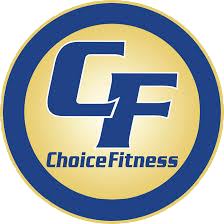

In [25]:
gspec = pn.GridSpec(width=800, height=600)
title = "Choice Fitness KPI Dashboard"
logo = 'choiceLogo.png'

gspec[0, 1:4] = pn.pane.HTML('<h1>Choice Fitness KPI Dashboard</h1>')
gspec[0, 0] = pn.pane.PNG(logo)
gspec[1:6, 0:4] = first_chart

gspec